Identifikasi:


*   Indonesia Violance Reporting Dataset




In [7]:
## SETUP
%pip install langchain_community -q
%pip install replicate -q
%pip install Sastrawi -q

In [8]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata

# Set the API token
REPLICATE_API_KEY = userdata.get('REPLICATE_API_KEY')
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_KEY

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
    model=model,
    replicate_api_token=REPLICATE_API_KEY,
)

# Dataset Extraction

In [9]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "indonesia-violence-reporting-text.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "fafafwzn/indonesia-violence-reporting-text",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/tmp/ipython-input-1126853194.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'indonesia-violence-reporting-text' dataset.


In [10]:
import pandas as pd

# df = pd.read_csv("/content/indonesia-violence-reporting-text.csv")
features = df.drop(columns=["Text"])
text = df["Text"]

df.head(3)

,Text,Layanan Hukum,Layanan Medis,Layanan Psikologis,Rehabilitasi Sosial,Jaminan Keselamatan,Layanan Pendidikan,Pengasuhan Pengganti,Bantuan Sosial
0,selamat sore saya adalah ibu dari satu anak sa...,1,1,0,0,0,0,0,0
1,mohon bantu pak saya sedang hamil pak diluar n...,0,0,0,0,0,0,1,0
2,saya seorang anak perempuan yang bersuami teta...,1,0,0,0,0,0,0,0


# EDA

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print(text.shape)
print(features.shape)

(85,)
(85, 8)


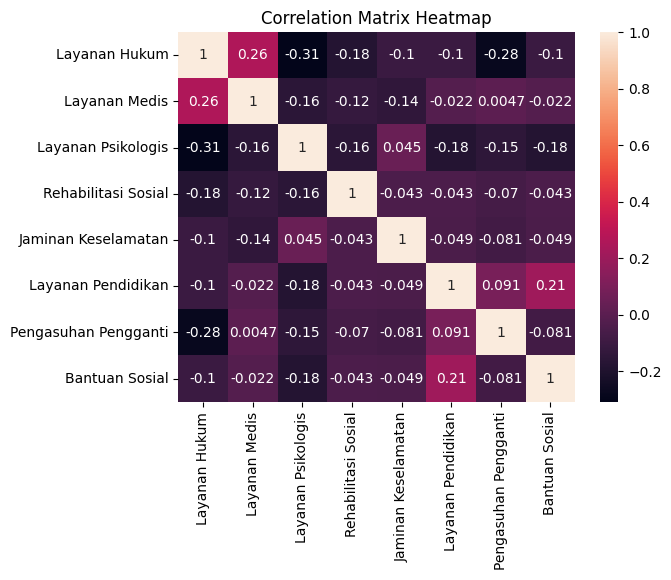

In [12]:
correlation_matrix = features.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [13]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
def preprocess_text(text):
    stop_factory = StopWordRemoverFactory()
    stopwords = stop_factory.get_stop_words()
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if word not in stopwords]
    return word_list

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
preprocessed_text = preprocess_text(' '.join(text))

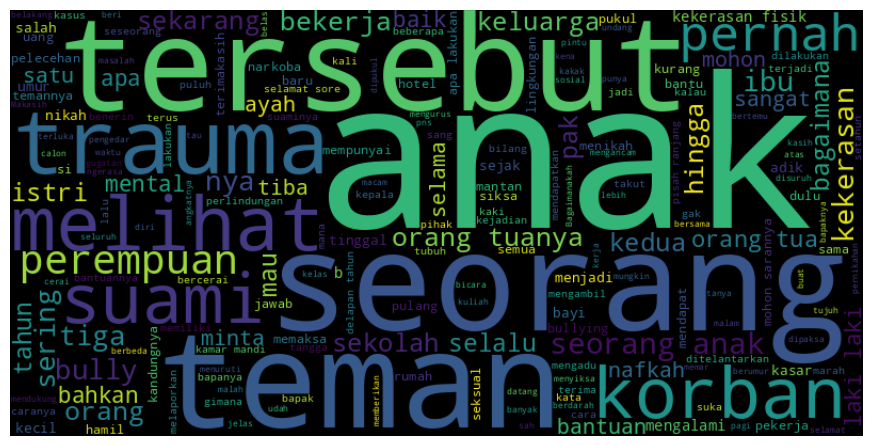

In [15]:
from wordcloud import WordCloud

text_wc = WordCloud(width=800, height=400, background_color='black').generate(' '.join(preprocessed_text))

fig, axes = plt.subplots(figsize=(11, 7))

plt.imshow(text_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# LLM Classification

In [16]:
parameters_v2 = {
    "top_p": 0.7,
    "max_tokens": 100,
    "min_tokens": 3,
    "random_seed": 42,
    "repetition_penalty": 1.1
}

In [56]:
prompt_context_v2 = f"""
## Answering steps
Complete the task in 2 steps.
First classify CATEGORY of text emotional distress which is the most prominent, between fear, anger, helpless, or sad
Second for each passage, identify what are the relevant NEEDS of the sender depending of the passage context, as either Legal services, Medical services, Psychological services, Social rehabilitation, Safety assurance, Education services, Subtitute care, Social assitance

## Response guide
Only output 1 CATEGORY and relevant NEEDS from the choice in this prompt. without explanation

## EXAMPLE
Input Text:
Review 1: selamat sore saya adalah ibu dari satu anak saya seorang janda mantan suami saya sampai sekarang masih sering menganiaya saya apa yang harus saya lakukan tolong bantuanya
Output Response:
Review n: CATEGORY: Fear NEEDS: Legal services, Medical services
"""


In [57]:
classfication_text = "\n".join([f"Report {i+1}: {review}" for i,
                                        review in enumerate(text[:15])])

classification_prompt = f"""
{prompt_context_v2}
{classfication_text}
"""

print("LLM Prompt:")
print(classification_prompt)


LLM Prompt:


## Answering steps
Complete the task in 2 steps.
First classify CATEGORY of text emotional distress which is the most prominent, between fear, anger, helpless, or sad
Second for each passage, identify what are the relevant NEEDS of the sender depending of the passage context, as either Legal services, Medical services, Psychological services, Social rehabilitation, Safety assurance, Education services, Subtitute care, Social assitance

## Response guide
Only output 1 CATEGORY and relevant NEEDS from the choice in this prompt. without explanation

## EXAMPLE
Input Text:
Review 1: selamat sore saya adalah ibu dari satu anak saya seorang janda mantan suami saya sampai sekarang masih sering menganiaya saya apa yang harus saya lakukan tolong bantuanya
Output Response:
Review n: CATEGORY: Fear NEEDS: Legal services, Medical services

Report 1: selamat sore saya adalah ibu dari satu anak saya seorang janda mantan suami saya sampai sekarang masih sering menganiaya saya apa yang h

In [58]:
# Invoke the model with the example prompt
response = output.invoke(classification_prompt, parameters=parameters_v2)

# Print the response
print("Granite Model Response:\n=============")
print(response)


Granite Model Response:
Review 1: CATEGORY: Fear NEEDS: Legal services
Report 2: CATEGORY: Fear NEEDS: Legal services, Medical services
Report 3: CATEGORY: Fear NEEDS: Legal services
Report 4: CATEGORY: Helpless NEEDS: Social assistance
Report 5: CATEGORY: Fear NEEDS: Legal services, Medical services, Safety assurance
Report 6: CATEGORY: Helpless NEEDS: Legal services
Report 7: CATEGORY: Helpless NEEDS: Social assistance
Report 8: CATEGORY: Fear NEEDS: Legal services, Social rehabilitation
Report 9: CATEGORY: Fear NEEDS: Legal services
Report 10: CATEGORY: Fear NEEDS: Legal services
Report 11: CATEGORY: Fear NEEDS: Legal services
Report 12: CATEGORY: Helpless NEEDS: Legal services
Report 13: CATEGORY: Fear NEEDS: Legal services
Report 14: CATEGORY: Fear NEEDS: Legal services
Report 15: CATEGORY: Anger NEEDS: Psychological services


In [59]:
# Split response to categories & needs

res = response.split("\n")
categories=[]
needs=[]
for i in res:
    try:
        answer = i.split("CATEGORY: ")[-1]
        answer_split = answer.split(" NEEDS: ")
        category = answer_split[0]
        need = answer_split[1]
        categories.append(category)
        needs.append(need)
    except:
        continue


In [60]:
## Extract dataset
label = ["Layanan Hukum", "Layanan Medis", "Layanan Psikologis", "Rehabilitasi Sosial", "Jaminan Keselamatan", "Layanan Pendidikan", "Pengasuhan Pengganti", "Bantuan Sosial"]
label_response = ["Legal services", "Medical services", "Psychological services", "Social rehabilitation", "Safety assurance", "Education services", "Subtitute care", "Social assistance"]
y_test = {"Layanan Hukum":[],
          "Layanan Medis":[],
          "Layanan Psikologis":[],
          "Rehabilitasi Sosial":[],
          "Jaminan Keselamatan":[],
          "Layanan Pendidikan":[],
          "Pengasuhan Pengganti":[],
          "Bantuan Sosial":[]
        }

for index, row in features.iterrows():
    for idx, i in enumerate(row):
        y_test[label[idx]].append(i)


In [61]:
print(y_test)

{'Layanan Hukum': [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'Layanan Medis': [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], 'Layanan Psikologis': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0], 'Rehabilitasi Sosial': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [77]:
import statistics
from sklearn.metrics import f1_score, precision_score, recall_score

prediction_binaries=[]
ground_truth_binaries=[]
total_accuracy = []
for review_index, i in enumerate(needs):
    needs_temp=[]
    prediction_binary = [0] * len(label)
    for j in i.split(", "):
        needs_temp.append(label_response.index(j))
    for idx in needs_temp:
        prediction_binary[idx] = 1
    ground_truth_binary = [y_test[lbl][review_index] for lbl in label]

    matches = 0
    for i in range(len(label)):
        if prediction_binary[i] == ground_truth_binary[i]:
            matches += 1

    prediction_binaries.append(prediction_binary)
    ground_truth_binaries.append(ground_truth_binary)

    accuracy = matches / len(label)
    total_accuracy.append(accuracy)

print("Multiclass Classification Accuracy:       ", statistics.mean(total_accuracy))
print("Multiclass Classification F1 Score:       ", f1_score(ground_truth_binaries, prediction_binaries, average="weighted"))
print("Multiclass Classification Precision Score:", precision_score(ground_truth_binaries, prediction_binaries, average="weighted", zero_division=0))
print("Multiclass Classification Recall Score:   ", recall_score(ground_truth_binaries, prediction_binaries, average="weighted", zero_division=0))

Multiclass Classification Accuracy:        0.8833333333333333
Multiclass Classification F1 Score:        0.6190476190476191
Multiclass Classification Precision Score: 0.6428571428571429
Multiclass Classification Recall Score:    0.6190476190476191


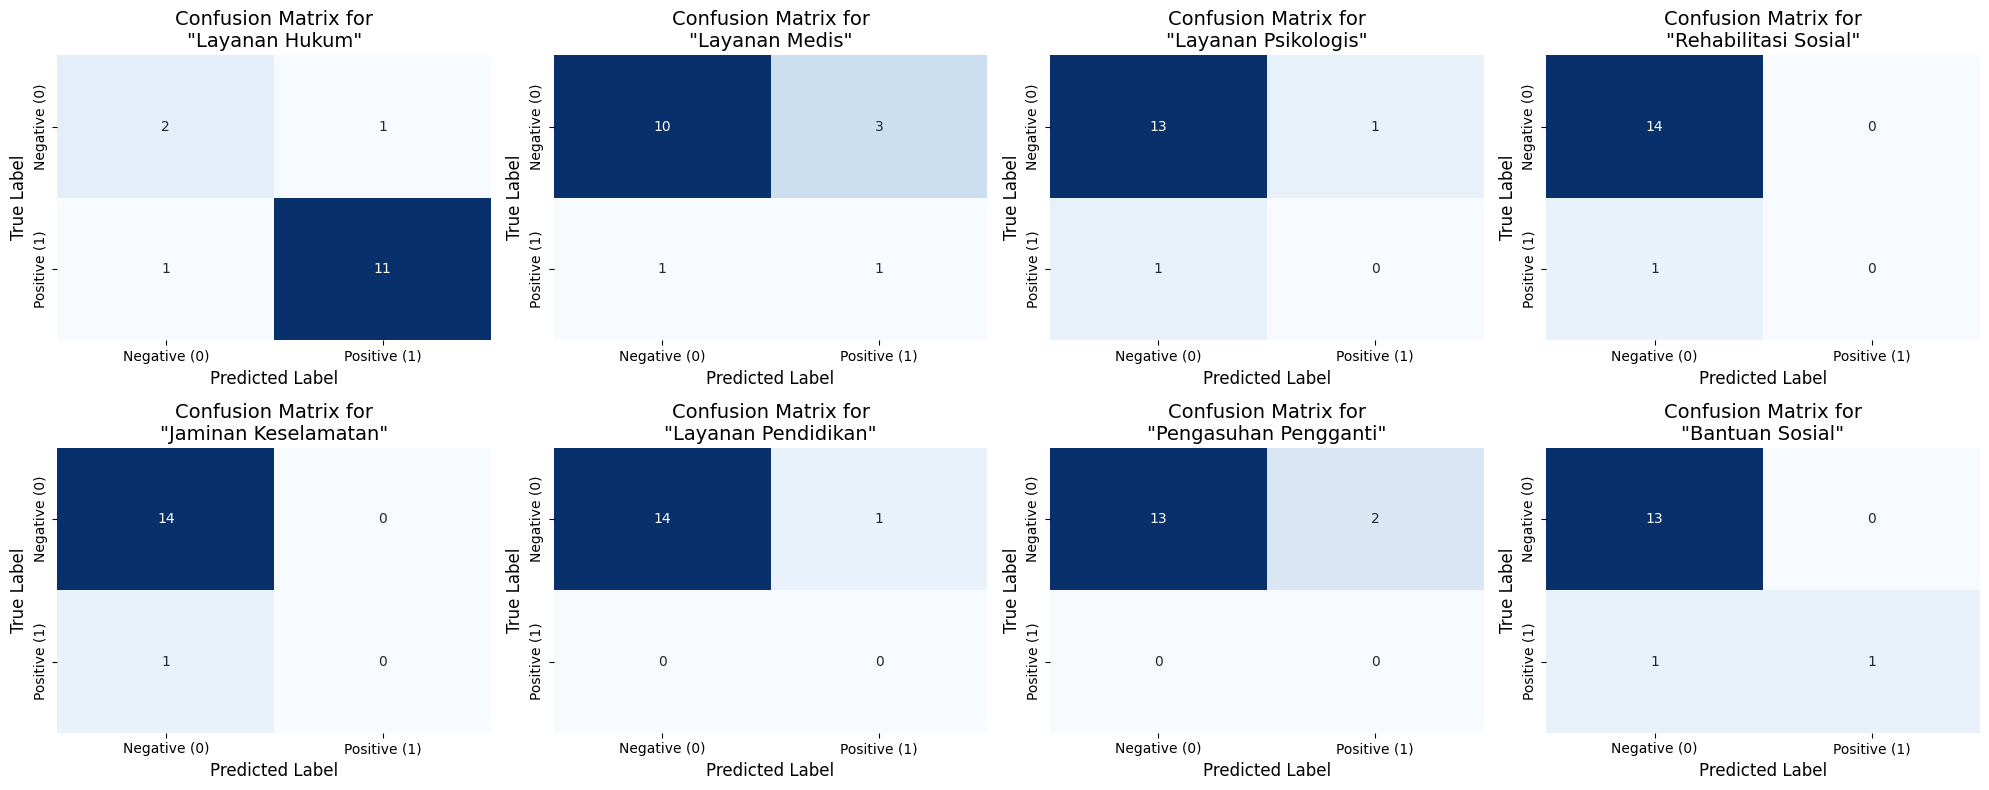

In [63]:
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = metrics.multilabel_confusion_matrix(prediction_binaries, ground_truth_binaries)

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for i, (matrix, label_name, ax) in enumerate(zip(confusion_matrix, label, axes.flatten())):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for\n"{label_name}"', fontsize=14)

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

    ax.set_xticklabels(['Negative (0)', 'Positive (1)'])
    ax.set_yticklabels(['Negative (0)', 'Positive (1)'])

plt.tight_layout()
plt.show()


# LLM Summarize

In [37]:
summary_parameters_v1 = {
    "top_p": 0.7,
    "max_tokens": 500,
    "min_tokens": 3,
    "random_seed": 42,
    "repetition_penalty": 1.1
}

In [38]:
summary_prompt_context = f"""
## Response guide
Summarize this text and find pattern regarding its sentiment, topics, and each potential root causes base on the text.
Structured the format with the following: Key Points Discussed, Explaination on overall Sentiment, and topic Items.

Include only concise bullet points under each heading.
"""

In [39]:
summarization_text = "\n".join([f"Report {i+1}: {review}" for i,
                                        review in enumerate(text)])

summarization_prompt = f"""
{summary_prompt_context}
{summarization_text}
"""

print("LLM Prompt:")
print(summarization_prompt)


LLM Prompt:


## Response guide
Summarize this text and find pattern regarding its sentiment, topics, and each potential root causes base on the text. 
Structured the format with the following: Key Points Discussed, Explaination on overall Sentiment, and topic Items.

Include only concise bullet points under each heading.

Report 1: selamat sore saya adalah ibu dari satu anak saya seorang janda mantan suami saya sampai sekarang masih sering menganiaya saya apa yang harus saya lakukan tolong bantuanya
Report 2: mohon bantu pak saya sedang hamil pak diluar nikah anak saya kembar pak tapi pacar saya ini tidak ingin bertanggung jawab dalam arti tidak ingin anak ini pak dia menghindar dan saya gak tau harus bagaimana pak dengan keadaan saya dengan keluarga
Report 3: saya seorang anak perempuan yang bersuami tetapi orang tua saya selalu ikut campur masalah saya dan ayah saya mengancam akan memukuli saya apa yang harus saya lakukan
Report 4: jika anak perempuan tidak di beri nafkah orang tua 

In [40]:
# Invoke the model with the example prompt
response = output.invoke(summarization_prompt, parameters=summary_parameters_v1)

# Print the response
print("Granite Model Response Summary:\n=============")
print(response)


Granite Model Response Summary:
**Key Points Discussed:**

- Family conflicts and domestic violence
- Unmarried pregnancies and child custody issues
- Elder abuse and neglect
- Bullying and psychological trauma
- Child labor and exploitation
- Parental alienation and interference in parent-child relationships
- Financial neglect and inability to support children
- Legal advice on reporting abuse and seeking protection

**Explanation on overall Sentiment:**
The overall sentiment of the reports is predominantly negative, as they describe various forms of abuse, neglect, and exploitation experienced by individuals, particularly children and the elderly. The reports express distress, fear, and a desire for guidance and support in dealing with these difficult situations.

**Topic Items:**

1. **Domestic Violence and Abuse**
   - Physical, emotional, and psychological abuse
   - Spousal abuse, partner violence
   - Child abuse, including physical violence and psychological manipulation

2. *